In [1]:
%matplotlib notebook

import os
import sys
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd
import time
import six
import re
from resampy import resample as resampy_resample

import torch
import pickle
import qgrid
from librosa.effects import harmonic
from librosa.core import estimate_tuning
from librosa.util.exceptions import ParameterError

import matplotlib.pyplot as plt
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy.io import wavfile
import scipy.fftpack as fftpack
from sklearn.neighbors import NearestNeighbors

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *

## Load data

In [2]:
data = pd.read_csv('../data/data.csv', index_col=0)

## Functions

In [3]:
# Functions 

def signal_frame(signal, index, frame_size, hop_size, origin=0):
    frame_size = int(frame_size)
    num_samples = len(signal)
    ref_sample = int(index * hop_size)
    start = ref_sample - frame_size // 2 - int(origin)
    stop = start + frame_size

    if (stop < 0) or (start > num_samples):
        # window falls completely outside the actual signal, return just zeros
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        return frame
    elif (start < 0) and (stop > num_samples):
        # window surrounds the actual signal, position signal accordingly
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:num_samples - start] = signal
        return frame
    elif start < 0:
        # window crosses left edge of actual signal, pad zeros from left
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:] = signal[:stop, ]
        return frame
    elif stop > num_samples:
        # window crosses right edge of actual signal, pad zeros from right
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[:num_samples - start] = signal[start:, ]
        return frame
    # normal read operation
    return signal[start:stop, ]


def slice_frames(signal, frame_size, hop_size):
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    frames = []    
    for index in range(num_frames):
        frames.append(signal_frame(signal, index, frame_size, hop_size))
    return np.asarray(frames)


def calculate_stft(frames):   
    num_frames = frames.shape[0]
    frame_size = frames.shape[1]
    num_fft_bins = frame_size >> 1 
    window = np.hamming(frame_size) 
    fft = np.empty((num_frames, num_fft_bins), np.complex64)
    for f, frame in enumerate(frames):
        fft_signal = np.multiply(frame, window)
        fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]
    return fft


def shift_right(values):
    return np.hstack([np.zeros((values.shape[0], 1)), values[..., :-1]])


def cross_spectrum(spectrumA, spectrumB):
    return spectrumA * spectrumB.conj()


def arg(values):
    return np.mod(np.angle(values) / (2 * np.pi), 1.0)


def estimate_instant_freqs(crossTimeSpectrum):
    return arg(crossTimeSpectrum)


def estimate_group_delays(crossFreqSpectrum):
    return 0.5 - arg(crossFreqSpectrum)


def select_positive_freq_fft(X):
    N = X.shape[1]
    return X[:, :N//2]

        
def pitch_to_freq(pitch, base_freq=440):
    factor = pitch_to_relative_freq(pitch)
    return factor * base_freq

    
def freq_to_pitch(freq, base_freq=440):
    steps_per_octave = 12
    rel_freq = freq / base_freq
    p = np.log2(rel_freq)
    return p * steps_per_octave

    
def pitch_to_relative_freq(pitch):
    octave_ratio = 2
    steps_per_octave = 12
    return pow(octave_ratio, pitch / steps_per_octave)


def pitch_quantize(freqs, base_freq=440, bin_division=1):
    return np.round(freq_to_pitch(freqs, base_freq) * bin_division) / bin_division


def transform_freqs(X_inst_freqs, sr=44100):
    bin_division = 1
    bin_range = (-48, 67) 

    quantization_border = 1 / (2 * bin_division)
    eps = np.finfo(np.float32).eps
    # TODO: is it possible to quantize using relative freqs to avoid
    # dependency on the fs parameter?
    X_y = pitch_quantize(np.maximum(sr * X_inst_freqs, eps) + quantization_border)
    output_bin_count = (bin_range[1] - bin_range[0]) * bin_division
    return X_y, output_bin_count, bin_range


# TODO: we should probably multiply the whole result by 2, to conserve energy
def positive_freq_magnitudes(X):
    X_pos = select_positive_freq_fft(X).copy()
    X_pos[:, 0] *= 0.5
    return X_pos


def db_scale(magnitude_spectrum, normalized=False):
    """
    Transform linear magnitude to dbFS (full-scale) [-120, 0] (for input range
    [0.0, 1.0]) which can be optionally normalized to [0.0, 1.0].
    """
    scaled = 20 * np.log10(np.maximum(1e-6, magnitude_spectrum))

    # map from raw dB [-120.0, 0] to [0.0, 1.0]
    if normalized:
        scaled = (scaled / 120) + 1
    return scaled


def scale_magnitudes(X_mag, transform):
    if transform == 'linear':
        return X_mag
    elif transform == 'power':
        return X_mag ** 2
    elif transform == 'power_db':
        return db_scale(X_mag ** 2)
    elif transform == 'power_db_normalized':
        return db_scale(X_mag ** 2, normalized=True)
    else:
        raise ValueError('Unknown magnitude scaling transform ' + transform)
        
        
def derive_window(window):
    lh = (window.shape[0] - 1) / 2.0
    step_height = (window[0] + window[-1]) / 2.0
    ramp = (window[0] - window[-1]) / (window.shape[0] - 1)
    base = np.arange(-lh, lh + 1)
    base = window - step_height - ramp * base
    base = np.hstack((np.array([0]), base, np.array([0])))
    dw = (base[2:(window.shape[0] + 2)] - base[:window.shape[0]]) / 2.0 + ramp
    dw[0] += step_height
    dw[-1] -= step_height
    return dw


def hz2mel(f):
    return 1127.01048 * np.log(np.asarray(f) / 700. + 1.)

def mel2hz(m):
    return 700. * (np.exp(np.asarray(m) / 1127.01048) - 1.)

def mel_frequencies(num_bands, fmin, fmax):
    return mel2hz(np.linspace(hz2mel(fmin), hz2mel(fmax), num_bands))

def frequencies2bins(frequencies, bin_frequencies):
    indices = bin_frequencies.searchsorted(frequencies)
    left = bin_frequencies[indices - 1]
    right = bin_frequencies[indices]
    indices -= frequencies - left < right - frequencies
    return indices

def bins2filterbank(bins, num_fft_bins):
    filterbank = []
    index = 0
    for index in range(len(bins)-2):
        start, center, end = bins[index: index + 3]
        filt = np.zeros(num_fft_bins)
        # rising edge (without the center)
        filt[start:center] = np.linspace(0, 1, center - start, endpoint=False)
        # falling edge (including the center, but without the last bin)
        filt[center:end] = np.linspace(1, 0, end - center, endpoint=False)
        filterbank.append(filt)
    return filterbank

def create_filterbank(bin_frequencies, num_fft_bins, num_bands = 20, fmin = 20., fmax = 17000.):
    frequencies = mel_frequencies(num_bands + 2, fmin, fmax)
    bins = frequencies2bins(frequencies, bin_frequencies)
    filterbank = bins2filterbank(bins, num_fft_bins)
    return np.asarray(filterbank)

def quantize_events(events, fps, length):
    events = np.array(events, dtype=np.float)
    
    events = events[:np.searchsorted(events, float(length - 0.5) / fps)]

    quantized = torch.zeros(length, dtype=torch.long)

    events *= fps
    
    # indices to be set in the quantized array
    idx = np.unique(np.round(events).astype(np.int))
    quantized[idx] = 1

    return quantized

def half_wave_rectifier(arr):
    return (np.abs(arr) + arr) / 2.0


def hamming_deriv(M):
    if M < 1:
        return array([])
    if M == 1:
        return ones(1, float)
    n = np.arange(0, M)
    return (2.89027*np.sin((6.28319*n)/(-1 + M)))/(-1 + M)

In [4]:
# constant q 

BW_BEST = 0.94759372
BW_FASTEST = 0.85


def cqt_frequencies(n_bins, fmin, bins_per_octave=12, tuning=0.0):
    correction = 2.0**(float(tuning) / bins_per_octave)
    frequencies = 2.0**(np.arange(0, n_bins, dtype=float) / bins_per_octave)
    return correction * fmin * frequencies


def note_to_hz(note, **kwargs):
    return midi_to_hz(note_to_midi(note, **kwargs))


def note_to_midi(note, round_midi=True):
    if not isinstance(note, six.string_types):
        return np.array([note_to_midi(n, round_midi=round_midi) for n in note])

    pitch_map = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}
    acc_map = {'#': 1, '': 0, 'b': -1, '!': -1}

    match = re.match(r'^(?P<note>[A-Ga-g])'
                     r'(?P<accidental>[#b!]*)'
                     r'(?P<octave>[+-]?\d+)?'
                     r'(?P<cents>[+-]\d+)?$',
                     note)
    if not match:
        raise ParameterError('Improper note format: {:s}'.format(note))

    pitch = match.group('note').upper()
    offset = np.sum([acc_map[o] for o in match.group('accidental')])
    octave = match.group('octave')
    cents = match.group('cents')

    if not octave:
        octave = 0
    else:
        octave = int(octave)

    if not cents:
        cents = 0
    else:
        cents = int(cents) * 1e-2

    note_value = 12 * (octave + 1) + pitch_map[pitch] + offset + cents

    if round_midi:
        note_value = int(np.round(note_value))

    return note_value



def midi_to_note(midi, octave=True, cents=False):
    if cents and not octave:
        raise ParameterError('Cannot encode cents without octave information.')

    if not np.isscalar(midi):
        return [midi_to_note(x, octave=octave, cents=cents) for x in midi]

    note_map = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    note_num = int(np.round(midi))
    note_cents = int(100 * np.around(midi - note_num, 2))

    note = note_map[note_num % 12]

    if octave:
        note = '{:s}{:0d}'.format(note, int(note_num / 12) - 1)
    if cents:
        note = '{:s}{:+02d}'.format(note, note_cents)

    return note


def midi_to_hz(notes):
    return 440.0 * (2.0 ** ((np.asanyarray(notes) - 69.0)/12.0))


def hz_to_midi(frequencies):
    return 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


def num_two_factors(x):
    if x <= 0:
        return 0
    num_twos = 0
    while x % 2 == 0:
        num_twos += 1
        x //= 2
    return num_twos


def early_downsample_count(nyquist, filter_cutoff, hop_length, n_octaves):
    downsample_count1 = max(0, int(np.ceil(np.log2(BW_FASTEST * nyquist /
                                                   filter_cutoff)) - 1) - 1)

    num_twos = num_two_factors(hop_length)
    downsample_count2 = max(0, num_twos - n_octaves + 1)

    return min(downsample_count1, downsample_count2)


def early_downsample(y, sr, hop_length, res_type, n_octaves,
                       nyquist, filter_cutoff, scale):
    downsample_count = early_downsample_count(nyquist, filter_cutoff,
                                                hop_length, n_octaves)

    if downsample_count > 0 and res_type == 'kaiser_fast':
        downsample_factor = 2**(downsample_count)

        hop_length //= downsample_factor

        if len(y) < downsample_factor:
            raise ParameterError('Input signal length={:d} is too short for '
                                 '{:d}-octave CQT'.format(len(y), n_octaves))

        new_sr = sr / float(downsample_factor)
        y = resample(y, sr, new_sr, res_type=res_type, scale=True)

        if not scale:
            y *= np.sqrt(downsample_factor)

    return y, new_sr, hop_length


def resample(y, orig_sr, target_sr, res_type='kaiser_best', fix=True, scale=False, **kwargs):
    if orig_sr == target_sr:
        return y

    ratio = float(target_sr) / orig_sr

    n_samples = int(np.ceil(y.shape[-1] * ratio))

    y_hat = resampy_resample(y, orig_sr, target_sr, filter=res_type, axis=-1)

    if fix:
        y_hat = fix_length(y_hat, n_samples, **kwargs)

    if scale:
        y_hat /= np.sqrt(ratio)

    return np.ascontiguousarray(y_hat, dtype=y.dtype)


def fix_length(data, size, axis=-1, **kwargs):
    kwargs.setdefault('mode', 'constant')

    n = data.shape[axis]

    if n > size:
        slices = [slice(None)] * data.ndim
        slices[axis] = slice(0, size)
        return data[tuple(slices)]

    elif n < size:
        lengths = [(0, 0)] * data.ndim
        lengths[axis] = (0, size - n)
        return np.pad(data, lengths, **kwargs)

    return data


def cqt_filter_fft(sr, fmin, n_bins, bins_per_octave, tuning,
                     filter_scale, norm, sparsity, hop_length=None,
                     window='hann'):
    
    basis, lengths = constant_q(sr, fmin=fmin, n_bins=n_bins, 
                                bins_per_octave=bins_per_octave, tuning=tuning,
                                filter_scale=filter_scale, norm=norm, window=window)

    # Filters are padded up to the nearest integral power of 2
    n_fft = basis.shape[1]

    if (hop_length is not None and
            n_fft < 2.0**(1 + np.ceil(np.log2(hop_length)))):

        n_fft = int(2.0 ** (1 + np.ceil(np.log2(hop_length))))

    # re-normalize bases with respect to the FFT window length
    basis *= lengths[:, np.newaxis] / float(n_fft)

    # FFT and retain only the non-negative frequencies
    fft_basis = fftpack.fft(basis, n=n_fft, axis=1)[:, :(n_fft // 2)+1]

    # sparsify the basis
    fft_basis = sparsify_rows(fft_basis, quantile=sparsity)

    return fft_basis, n_fft, lengths


def sparsify_rows(x, quantile=0.01):
    if x.ndim == 1:
        x = x.reshape((1, -1))

    elif x.ndim > 2:
        raise ParameterError('Input must have 2 or fewer dimensions. '
                             'Provided x.shape={}.'.format(x.shape))

    if not 0.0 <= quantile < 1:
        raise ParameterError('Invalid quantile {:.2f}'.format(quantile))

    x_sparse = scipy.sparse.lil_matrix(x.shape, dtype=x.dtype)

    mags = np.abs(x)
    norms = np.sum(mags, axis=1, keepdims=True)

    mag_sort = np.sort(mags, axis=1)
    cumulative_mag = np.cumsum(mag_sort / norms, axis=1)

    threshold_idx = np.argmin(cumulative_mag < quantile, axis=1)

    for i, j in enumerate(threshold_idx):
        idx = np.where(mags[i] >= mag_sort[i, j])
        x_sparse[i, idx] = x[i, idx]

    return x_sparse.tocsr()


def constant_q(sr, fmin=None, n_bins=84, bins_per_octave=12, tuning=0.0,
               window='hann', filter_scale=1, norm=1):
    if fmin is None:
        fmin = note_to_hz('C1')
        
    # To Do: integrate 'here', without extra function
    lengths = constant_q_lengths(sr, fmin, n_bins=n_bins, bins_per_octave=bins_per_octave,
                                 tuning=tuning, window=window, filter_scale=filter_scale)

    correction = 2.0**(float(tuning) / bins_per_octave)
    fmin = correction * fmin

    Q = float(filter_scale) / (2.0**(1. / bins_per_octave) - 1)

    freqs = Q * sr / lengths

    filters = []
    for ilen, freq in zip(lengths, freqs):
        # length will be ceil(ilen)
        sig = np.exp(np.arange(-ilen//2, ilen//2, dtype=float) * 1j * 2 * np.pi * freq / sr)
        sig = sig * float_window(window, len(sig))
        sig = normalize(sig, norm=norm)
        filters.append(sig)

    # Pad and stack
    max_len = max(lengths)
    max_len = int(2.0**(np.ceil(np.log2(max_len))))

    filters = np.asarray([pad_center(filt, max_len) for filt in filters])

    return filters, np.asarray(lengths)


def float_window(window_spec, n):
    n_min, n_max = int(np.floor(n)), int(np.ceil(n))

    window = get_window(window_spec, n_min)

    if len(window) < n_max:
        window = np.pad(window, [(0, n_max - len(window))], mode='constant')
    window[n_min:] = 0.0

    return window

In [5]:
# constant q 2

def constant_q_lengths(sr, fmin, n_bins=84, bins_per_octave=12,
                       tuning=0.0, window='hann', filter_scale=1):

    correction = 2.0**(float(tuning) / bins_per_octave)

    fmin = correction * fmin

    Q = float(filter_scale) / (2.0**(1. / bins_per_octave) - 1)

    freq = fmin * (2.0 ** (np.arange(n_bins, dtype=float) / bins_per_octave))

    if freq[-1] * (1 + 0.5 * window_bandwidth(window) / Q) > sr / 2.0:
        raise ParameterError('Filter pass-band lies beyond Nyquist')

    # Convert frequencies to filter lengths
    lengths = Q * sr / freq

    return lengths


def window_bandwidth(window):
    return WINDOW_BANDWIDTHS[window]


WINDOW_BANDWIDTHS = {'blackman': 1.7269681554262326,
                     'hamm': 1.3629455320350348,
                     'hamming': 1.3629455320350348,
                     'hann': 1.50018310546875,
                     'hanning': 1.50018310546875}


def cqt_response(y, n_fft, hop_length, fft_basis, mode):
    X = stft(y, n_fft=n_fft, hop_length=hop_length, window='ones', pad_mode=mode)
    return fft_basis.dot(X)


def stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann',
         center=True, dtype=np.complex64, pad_mode='reflect'):
    if win_length is None:
        win_length = n_fft

    if hop_length is None:
        hop_length = int(win_length // 4)

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    fft_window = fft_window.reshape((-1, 1))


    # Pad the time series so that frames are centered
    if center:
        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    # Window the time series.
    y_frames = frame(y, frame_length=n_fft, hop_length=hop_length)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty((int(1 + n_fft // 2), y_frames.shape[1]),
                           dtype=dtype,
                           order='F')
    
    MAX_MEM_BLOCK = 2**8 * 2**10

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = int(MAX_MEM_BLOCK / (stft_matrix.shape[0] *
                                          stft_matrix.itemsize))

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        # RFFT and Conjugate here to match phase from DPWE code
        stft_matrix[:, bl_s:bl_t] = fftpack.fft(fft_window *
                                            y_frames[:, bl_s:bl_t],
                                            axis=0)[:stft_matrix.shape[0]]

    return stft_matrix


def get_window(window, Nx, fftbins=True):
    if six.callable(window):
        return window(Nx)

    elif (isinstance(window, (six.string_types, tuple)) or
          np.isscalar(window)):
        return scipy.signal.get_window(window, Nx, fftbins=fftbins)

    elif isinstance(window, (np.ndarray, list)):
        if len(window) == Nx:
            return np.asarray(window)

        raise ParameterError('Window size mismatch: '
                             '{:d} != {:d}'.format(len(window), Nx))
    else:
        raise ParameterError('Invalid window specification: {}'.format(window))
        
        
def pad_center(data, size, axis=-1):
    n = data.shape[axis]

    lpad = int((size - n) // 2)

    lengths = [(0, 0)] * data.ndim
    lengths[axis] = (lpad, int(size - n - lpad))

    if lpad < 0:
        raise ParameterError(('Target size ({:d}) must be '
                              'at least input size ({:d})').format(size, n))

    return np.pad(data, lengths, 'constant')


def frame(y, frame_length=2048, hop_length=512):
    if not isinstance(y, np.ndarray):
        raise ParameterError('Input must be of type numpy.ndarray, '
                             'given type(y)={}'.format(type(y)))

    if y.ndim != 1:
        raise ParameterError('Input must be one-dimensional, '
                             'given y.ndim={}'.format(y.ndim))

    if len(y) < frame_length:
        raise ParameterError('Buffer is too short (n={:d})'
                             ' for frame_length={:d}'.format(len(y), frame_length))

    if hop_length < 1:
        raise ParameterError('Invalid hop_length: {:d}'.format(hop_length))

    if not y.flags['C_CONTIGUOUS']:
        raise ParameterError('Input buffer must be contiguous.')

    # Compute the number of frames that will fit. The end may get truncated.
    n_frames = 1 + int((len(y) - frame_length) / hop_length)

    # Vertical stride is one sample
    # Horizontal stride is `hop_length` samples
    y_frames = as_strided(y, shape=(frame_length, n_frames),
                          strides=(y.itemsize, hop_length * y.itemsize))
    return y_frames


def trim_stack(cqt_resp, n_bins):
    # cleanup any framing errors at the boundaries
    max_col = min(x.shape[1] for x in cqt_resp)

    cqt_resp = np.vstack([x[:, :max_col] for x in cqt_resp][::-1])

    # Finally, clip out any bottom frequencies that we don't really want
    # Transpose magic here to ensure column-contiguity
    return np.ascontiguousarray(cqt_resp[-n_bins:].T).T


def tiny(x):
    # Make sure we have an array view
    x = np.asarray(x)

    # Only floating types generate a tiny
    if np.issubdtype(x.dtype, np.floating) or np.issubdtype(x.dtype, np.complexfloating):
        dtype = x.dtype
    else:
        dtype = np.float32

    return np.finfo(dtype).tiny


def normalize(S, norm=np.inf, axis=0, threshold=None, fill=None):
    # Avoid div-by-zero
    if threshold is None:
        threshold = tiny(S)

    elif threshold <= 0:
        raise ParameterError('threshold={} must be strictly '
                             'positive'.format(threshold))

    if fill not in [None, False, True]:
        raise ParameterError('fill={} must be None or boolean'.format(fill))

    if not np.all(np.isfinite(S)):
        raise ParameterError('Input must be finite')

    # All norms only depend on magnitude, let's do that first
    mag = np.abs(S).astype(np.float)

    # For max/min norms, filling with 1 works
    fill_norm = 1

    if norm == np.inf:
        length = np.max(mag, axis=axis, keepdims=True)

    elif norm == -np.inf:
        length = np.min(mag, axis=axis, keepdims=True)

    elif norm == 0:
        if fill is True:
            raise ParameterError('Cannot normalize with norm=0 and fill=True')

        length = np.sum(mag > 0, axis=axis, keepdims=True, dtype=mag.dtype)

    elif np.issubdtype(type(norm), np.number) and norm > 0:
        length = np.sum(mag**norm, axis=axis, keepdims=True)**(1./norm)

        if axis is None:
            fill_norm = mag.size**(-1./norm)
        else:
            fill_norm = mag.shape[axis]**(-1./norm)

    elif norm is None:
        return S

    else:
        raise ParameterError('Unsupported norm: {}'.format(repr(norm)))

    # indices where norm is below the threshold
    small_idx = length < threshold

    Snorm = np.empty_like(S)
    if fill is None:
        # Leave small indices un-normalized
        length[small_idx] = 1.0
        Snorm[:] = S / length

    elif fill:
        # If we have a non-zero fill value, we locate those entries by
        # doing a nan-divide.
        # If S was finite, then length is finite (except for small positions)
        length[small_idx] = np.nan
        Snorm[:] = S / length
        Snorm[np.isnan(Snorm)] = fill_norm
    else:
        # Set small values to zero by doing an inf-divide.
        # This is safe (by IEEE-754) as long as S is finite.
        length[small_idx] = np.inf
        Snorm[:] = S / length

    return Snorm


def cq_to_chroma(n_input, bins_per_octave=12, n_chroma=12,
                 fmin=None, window=None, base_c=True):

    # How many fractional bins are we merging?
    n_merge = float(bins_per_octave) / n_chroma

    if fmin is None:
        fmin = note_to_hz('C1')

    if np.mod(n_merge, 1) != 0:
        raise ParameterError('Incompatible CQ merge: '
                             'input bins must be an '
                             'integer multiple of output bins.')

    # Tile the identity to merge fractional bins
    cq_to_ch = np.repeat(np.eye(n_chroma), n_merge, axis=1)

    # Roll it left to center on the target bin
    cq_to_ch = np.roll(cq_to_ch, - int(n_merge // 2), axis=1)

    # How many octaves are we repeating?
    n_octaves = np.ceil(np.float(n_input) / bins_per_octave)

    # Repeat and trim
    cq_to_ch = np.tile(cq_to_ch, int(n_octaves))[:, :n_input]

    # What's the note number of the first bin in the CQT?
    # midi uses 12 bins per octave here
    midi_0 = np.mod(hz_to_midi(fmin), 12)

    if base_c:
        # rotate to C
        roll = midi_0
    else:
        # rotate to A
        roll = midi_0 - 9

    # Adjust the roll in terms of how many chroma we want out
    # We need to be careful with rounding here
    roll = int(np.round(roll * (n_chroma / 12.)))

    # Apply the roll
    cq_to_ch = np.roll(cq_to_ch, roll, axis=0).astype(float)

    if window is not None:
        cq_to_ch = scipy.signal.convolve(cq_to_ch,
                                         np.atleast_2d(window),
                                         mode='same')

    return cq_to_ch

In [6]:
def cqt(y, sr=44100, hop_length=512, fmin=note_to_hz('C1'), n_bins=84,
        bins_per_octave=12, tuning=0.0, filter_scale=1, norm=1, 
        sparsity=0.01, window='hann', scale=True, pad_mode='reflect'):

    n_octaves = int(np.ceil(float(n_bins) / bins_per_octave))
    n_filters = min(bins_per_octave, n_bins)

    if tuning is None:
        tuning = estimate_tuning(y=y, sr=sr)
            
    # freqs of the top octave
    freqs = cqt_frequencies(n_bins, fmin, 
                            bins_per_octave=bins_per_octave)[-bins_per_octave:]

    fmin_t = np.min(freqs)
    fmax_t = np.max(freqs)

    Q = float(filter_scale) / (2.0**(1. / bins_per_octave) - 1) 
     
    filter_cutoff = fmax_t * (1 + 0.5 * window_bandwidth(window) / Q)
    nyquist = sr / 2.0
    if filter_cutoff < BW_FASTEST * nyquist:
        res_type = 'kaiser_fast'
    else:
        res_type = 'kaiser_best'

    y, sr, hop_length = early_downsample(y, sr, hop_length, res_type, n_octaves,
                                           nyquist, filter_cutoff, scale)
    
    cqt_resp = []

    if res_type != 'kaiser_fast':

        # Do the top octave before resampling to allow for fast resampling
        fft_basis, n_fft, _ = __cqt_filter_fft(sr, fmin_t, n_filters, bins_per_octave,
                                               tuning, filter_scale, norm, sparsity,
                                               window=window)

        # Compute the CQT filter response and append it to the stack
        cqt_resp.append(__cqt_response(y, n_fft, hop_length, fft_basis, pad_mode))

        fmin_t /= 2
        fmax_t /= 2
        n_octaves -= 1

        filter_cutoff = fmax_t * (1 + 0.5 * window_bandwidth(window) / Q)

        res_type = 'kaiser_fast'

    # Make sure our hop is long enough to support the bottom octave
    num_twos = num_two_factors(hop_length)
    if num_twos < n_octaves - 1:
        raise ParameterError('hop_length must be a positive integer '
                             'multiple of 2^{0:d} for {1:d}-octave CQT'
                             .format(n_octaves - 1, n_octaves))

    # Now do the recursive bit
    fft_basis, n_fft, _ = cqt_filter_fft(sr, fmin_t, n_filters, bins_per_octave,
                                           tuning, filter_scale, norm, sparsity,
                                           window=window)

    my_y, my_sr, my_hop = y, sr, hop_length

    # Iterate down the octaves
    for i in range(n_octaves):
        # Resample (except first time)
        if i > 0:
            if len(my_y) < 2:
                raise ParameterError('Input signal length={} is too short for '
                                     '{:d}-octave CQT'.format(len(y), n_octaves))

            my_y = resample(my_y, my_sr, my_sr/2.0, res_type=res_type, scale=True)
            # The re-scale the filters to compensate for downsampling
            fft_basis[:] *= np.sqrt(2)

            my_sr /= 2.0
            my_hop //= 2

        cqt_resp.append(cqt_response(my_y, n_fft, my_hop, fft_basis, pad_mode))

    C = trim_stack(cqt_resp, n_bins)

    if scale:
        lengths = constant_q_lengths(sr, fmin, n_bins=n_bins, bins_per_octave=bins_per_octave,
                                     tuning=tuning, window=window, filter_scale=filter_scale)
        
        C /= np.sqrt(lengths[:, np.newaxis])

    return C

In [7]:
# chroma 

def chroma_cqt(y=None, sr=44100, hop_length=512, fmin=None,
               norm=np.inf, threshold=0.0, tuning=None, n_chroma=12,
               n_octaves=7, window=None, bins_per_octave=None, cqt_mode='full'):
#     cqt_func = {'full': cqt, 'hybrid': hybrid_cqt}

    if bins_per_octave is None:
        bins_per_octave = n_chroma

    C = np.abs(cqt(y, sr=sr, hop_length=hop_length,fmin=fmin, 
                   n_bins=n_octaves*bins_per_octave,
                   bins_per_octave=bins_per_octave, tuning=tuning))

    # Map to chroma
    cq_to_chr = cq_to_chroma(C.shape[0], bins_per_octave=bins_per_octave, 
                             n_chroma=n_chroma, fmin=fmin, window=window)
    chroma = cq_to_chr.dot(C)

    if threshold is not None:
        chroma[chroma < threshold] = 0.0

    # Normalize
    if norm is not None:
        chroma = normalize(chroma, norm=norm, axis=0)

    return chroma


def chroma_cens(y=None, sr=44100, hop_length=512, fmin=None,
                tuning=None, n_chroma=12, n_octaves=7, bins_per_octave=None, 
                cqt_mode='full', window=None, norm=2, win_len_smooth=41):
    
    chroma = chroma_cqt(y=y, sr=sr, hop_length=hop_length, fmin=fmin,
                        bins_per_octave=bins_per_octave, tuning=tuning,
                        norm=None, n_chroma=n_chroma, n_octaves=n_octaves,
                        cqt_mode=cqt_mode, window=window)

    # L1-Normalization
    chroma = normalize(chroma, norm=1, axis=0)

    # Quantize amplitudes
    QUANT_STEPS = [0.4, 0.2, 0.1, 0.05]
    QUANT_WEIGHTS = [0.25, 0.25, 0.25, 0.25]

    chroma_quant = np.zeros_like(chroma)

    for cur_quant_step_idx, cur_quant_step in enumerate(QUANT_STEPS):
        chroma_quant += (chroma > cur_quant_step) * QUANT_WEIGHTS[cur_quant_step_idx]

    # Apply temporal smoothing
    win = get_window('hann', win_len_smooth + 2, fftbins=False)
    win /= np.sum(win)
    win = np.atleast_2d(win)

    cens = scipy.signal.convolve2d(chroma_quant, win, mode='same', boundary='fill')

    # L2-Normalization
    return normalize(cens, norm=norm, axis=0)


def chroma_cho(y=None, sr=44100, hop_length=512, fmin=None, M=25, tau=1, theta=50,
              n_chroma=12, n_octaves=7, bins_per_octave=None):
    
#     chroma = chroma_cqt(y=y, sr=sr, hop_length=hop_length, fmin=fmin,
#                         bins_per_octave=bins_per_octave, n_chroma=n_chroma, 
#                         n_octaves=n_octaves)
    
    chroma = chroma_crp(y=y, sr=sr, hop_length=512, fmin=fmin,
                     n_chroma=12, n_octaves=7, bins_per_octave=36)
    
    bins = chroma.shape[0]
    T = chroma.shape[1]
    N = T - M
    
    W, C_hat = weight_matrix(chroma, M=M, tau=tau, theta=theta)
    
    C = np.zeros(C_hat.shape)
        
    # To Do: optimize     
    for n in range(N):
        print("Progress {:d} of {:d}".format(n+1, N), end="\r")
        for m in range(min(M,n+1)):
            nominator = np.matmul(W[:,n-m].T, C_hat)
            denominator = sum(W[:,n-m])
            C[n,:] += nominator/denominator
            
    chroma_cho = C[:,np.arange(0,C.shape[1],M)].T
    
    # To Do: append last values 

    return normalize(chroma_cho, norm=2, axis=0)

In [8]:
# recurrence matrix

def weight_matrix(chroma, M=25, tau=1, theta=50):
    W = None
    
    bins = chroma.shape[0]
    T = chroma.shape[1]
    N = T - M
    
    C_hat = np.empty((N, bins*M))

    for n in range(N):
        C_hat[n,:] = np.asarray([chroma[k,n:n+M*tau] for k in range(bins)]).flatten()
    
    C_hat = normalize(C_hat, norm=2, axis=1)
    
    R = np.zeros((N, N))
    S = np.zeros((N, N))
    
    knn = NearestNeighbors(n_neighbors=theta, metric='euclidean', algorithm='auto')
    knn.fit(C_hat)
    
    for i in range(N):
        ind = knn.kneighbors([C_hat[i,:]], return_distance=False)[0]   
        R[i,ind] = 1.0
        R[ind,i] = 1.0
        for j in ind[ind < i]:
            a_min_b = C_hat[i,:] - C_hat[j,:]
            S[i,j] = np.sqrt(np.einsum('i,i->', a_min_b, a_min_b))/2.0 
                        
    S = S + S.T 
        
    W = (1.0 - S) * R
    
    return W, C_hat

In [9]:
# chroma mueller

def mfcc(y=None, sr=44100, S=None, n_mfcc=20, dct_type=2, norm='ortho', **kwargs):
    if S is None:
        S = power_to_db(melspectrogram(y=y, sr=sr, **kwargs))

    return scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_mfcc]


def chroma_crp(y=None, sr=44100, hop_length=512, fmin=None, C=100, n_mfcc=120,
              n=55, n_chroma=12, n_octaves=7, bins_per_octave=36):
    
    pitchgram = np.abs(cqt(y=y, sr=sr, hop_length=hop_length, fmin=fmin, 
                           n_bins=n_octaves*bins_per_octave, 
                           bins_per_octave=bins_per_octave, tuning=None))
    
#     pitchgram = np.pad(pitchgram, (23,13), mode='constant')
    
    pitchgram = np.log(C*np.square(pitchgram) + 1)
    
    pfcc = scipy.fftpack.dct(pitchgram, axis=0, type=2, norm='ortho')
    
    pfcc[:n,:] = 0.0
    
    dct_reduced_pitchgram = scipy.fftpack.idct(pfcc, axis=0, type=2, norm='ortho')
    
    # Map to chroma
    cq_to_chr = cq_to_chroma(dct_reduced_pitchgram.shape[0], bins_per_octave=bins_per_octave, 
                             n_chroma=n_chroma, fmin=fmin)
    chroma = cq_to_chr.dot(dct_reduced_pitchgram)
    
    return normalize(chroma, norm=2, axis=0)

## Chroma

In [10]:
sr = 44100
frame_size = 2048
frame_rate = 100
hop_size = int(sr/frame_rate)
new_frame_rate = int(sr/256) 
fmin = note_to_hz('C1')    # 32.7 Hz

In [11]:
idx = 750
file = data.at[idx,'file']

signal = get_audio(file, normalize=True)
annotations = get_annotations(file)

pitchgram = np.abs(cqt(y=signal, sr=sr, hop_length=512, fmin=fmin, 
                   n_bins=7*36, bins_per_octave=36, tuning=None))

chroma = chroma_cqt(y=signal, sr=sr, hop_length=512, fmin=fmin,
                tuning=None, n_chroma=12, n_octaves=7, bins_per_octave=36)

chroma2 = chroma_crp(y=signal, sr=sr, hop_length=512, fmin=fmin,
                     n_chroma=12, n_octaves=7, bins_per_octave=36)

chroma3 = chroma_cho(y=signal, sr=sr, hop_length=512, fmin=fmin, M=25, tau=1, 
                     theta=50, n_chroma=12, n_octaves=7, bins_per_octave=36)

<IPython.core.display.Javascript object>


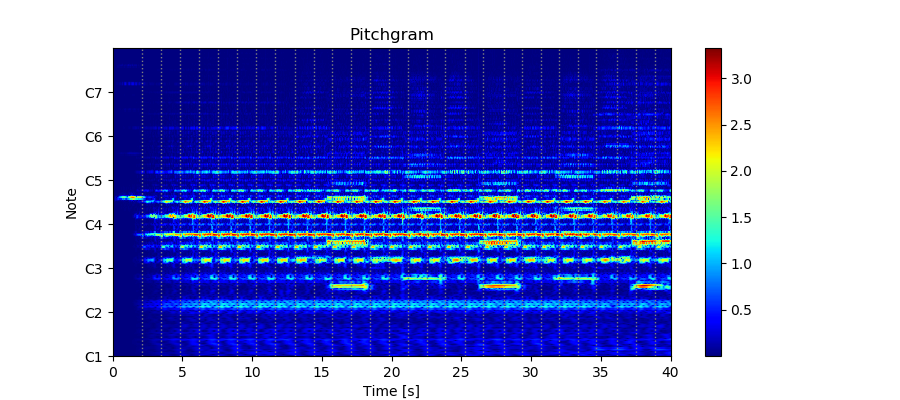

<IPython.core.display.Javascript object>


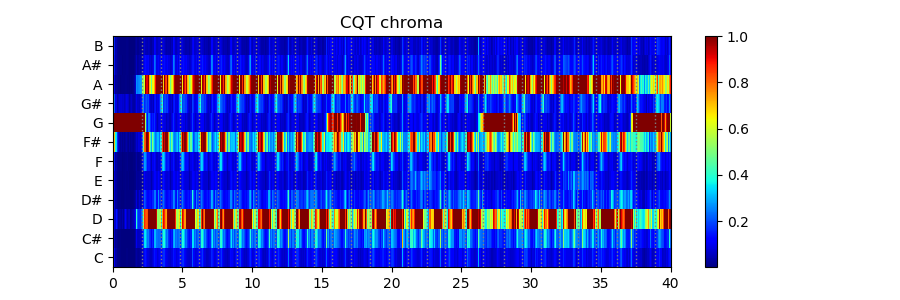

<IPython.core.display.Javascript object>


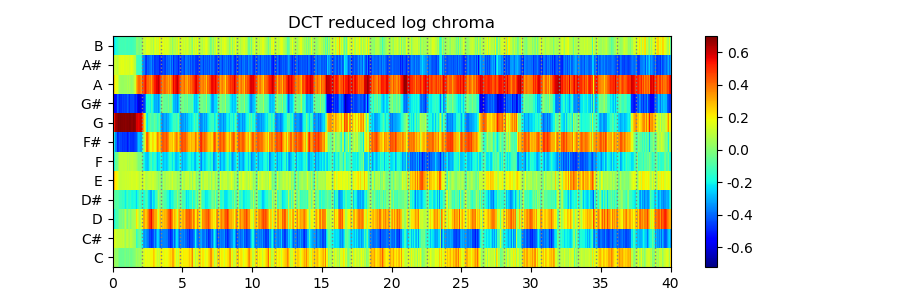

<IPython.core.display.Javascript object>


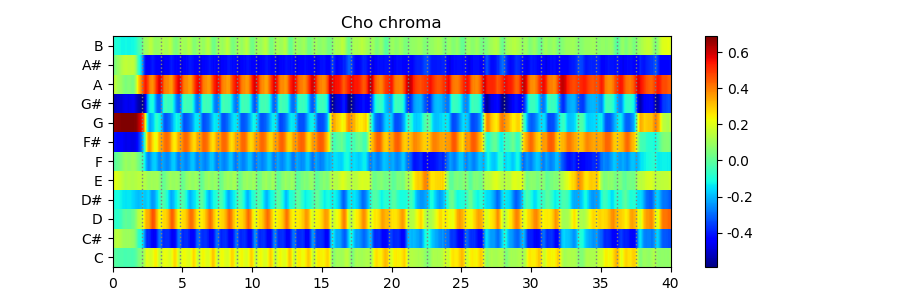

In [13]:
# plots  

plt.figure(figsize=(9,4))
plt.title('Pitchgram')
plt.imshow(np.log(2*pitchgram+1), origin='lower', aspect='auto', cmap='jet', 
           extent=(0, len(signal)/sr, 0, pitchgram.shape[0]))
plt.colorbar(format='%.1f');
plt.yticks(np.arange(0,pitchgram.shape[0],36), ['C1','C2','C3','C4','C5','C6','C7'])
for ann in annotations:
        plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);
plt.xlabel('Time [s]');
plt.ylabel('Note');


plt.figure(figsize=(9,3))
plt.title('CQT chroma')
plt.imshow(chroma, origin='lower', aspect='auto', cmap='jet', extent=(0, len(signal)/sr, -0.5, 11.5))
plt.colorbar(format='%.1f');
plt.yticks(np.arange(12), ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'])
for ann in annotations:
        plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);
        
        
plt.figure(figsize=(9,3))
plt.title('DCT reduced log chroma')
plt.imshow(chroma2, origin='lower', aspect='auto', cmap='jet', extent=(0, len(signal)/sr, -0.5, 11.5))
plt.colorbar(format='%.1f');
plt.yticks(np.arange(12), ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'])
for ann in annotations:
        plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);
        
        
plt.figure(figsize=(9,3))
plt.title('Cho chroma')
plt.imshow(chroma3, origin='lower', aspect='auto', cmap='jet', extent=(0, len(signal)/sr, -0.5, 11.5))
plt.colorbar(format='%.1f');
plt.yticks(np.arange(12), ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'])
for ann in annotations:
        plt.axvline(x=ann, color='grey', linestyle=':', linewidth=1);
        

In [276]:
play_audio(file)

## Calculate spectrogram (frame size 2048)

In [13]:
sr = 44100
frame_size = 2048
frame_rate = 100
hop_size = sr/frame_rate
window = np.hamming(frame_size) 
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_sizes, 1. / sr)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')

In [84]:
files = data['file'][data['data_set'] == 1]

start = time.time()
for i, file in enumerate(files):  
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    signal = get_audio(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    feature = []
    frames = []    

    # Slice audio into frames
    for index in range(num_frames):
        frames.append(signal_frame(signal, index, frame_size, hop_size))

    # Compute FFT    
    fft = np.empty((num_frames, num_fft_bins), np.complex64)
    for f, frame in enumerate(frames):
        fft_signal = np.multiply(frame, window)
        fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

    abs_fft = np.square(np.abs(fft))

    filt_spec = np.log(np.dot(abs_fft, filterbank.T) + 1.0)

    shift_length = np.int(frame_size/100.)  # attention: hyperparameter

    median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
              [:-shift,:] for shift in range(1, shift_length+1)]
    median = np.insert(median, 0, filt_spec, axis=0)
    median = np.median(median, axis=0)

    diff_spec = half_wave_rectifier(filt_spec - median)
    diff_spec[:shift_length,:] = 0

    feature.append(torch.tensor(filt_spec, dtype=torch.float32)) 
    feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
    feature_vec = torch.cat(feature, 1)
    pickle.dump(feature_vec, open('../data/inputs/2048/' + '/' +
                                  file + '.npy', 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 698 of 698
Elapsed time: 3 min and 30 s


## Process files (3 frame sizes)

In [80]:
normalize = False 
sample_rate = 44100
sr = sample_rate
frame_sizes = [1024, 2048, 4096]
frame_rate = 100
hop_size = sample_rate/frame_rate
window = [np.hamming(frame_size) for frame_size in frame_sizes]
num_fft_bins = [frame_size >> 1 for frame_size in frame_sizes]

bin_frequencies = []
for i in range(len(frame_sizes)):
    bin_frequencies.append(np.fft.fftfreq(frame_sizes[i], 1. / sample_rate)[:num_fft_bins[i]])
    
filterbank = []
for i in range(len(frame_sizes)):
    filterbank.append(np.array(create_filterbank(bin_frequencies[i], num_fft_bins[i]), dtype='float32'))

In [81]:
files = data['file'][data['data_set'] == 3]

start = time.time()
for i, file in enumerate(files):  
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    signal = get_audio(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    feature = []
    
    for j, frame_size in enumerate(frame_sizes): 
    
        frames = []    

        # Slice audio into frames
        for index in range(num_frames):
            frames.append(signal_frame(signal, index, frame_size, hop_size))

        # Compute FFT    
        fft = np.empty((num_frames, num_fft_bins[j]), np.complex64)

        for f, frame in enumerate(frames):
            fft_signal = np.multiply(frame, window[j])
            fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins[j]]

        abs_fft = np.square(np.abs(fft))

        filt_spec = np.log(np.dot(abs_fft, filterbank[j].T) + 1.0)
        
        shift_length = np.int(frame_size/100.)
        
        median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
                  [:-shift,:] for shift in range(1, shift_length+1)]
        median = np.insert(median, 0, filt_spec, axis=0)
        median = np.median(median, axis=0)
        
        diff_spec = half_wave_rectifier(filt_spec - median)
        diff_spec[:shift_length,:] = 0
        
        if normalize:
            filt_spec = filt_spec - np.min(filt_spec)
            filt_spec = filt_spec / np.max(filt_spec)
            diff_spec = diff_spec - np.min(diff_spec)
            diff_spec = diff_spec / np.max(diff_spec)
               
        feature.append(torch.tensor(filt_spec, dtype=torch.float32)) 
        feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
    feature_vec = torch.cat(feature, 1)
    pickle.dump(feature_vec, open('../data/inputs/{}.npy'.format(file), 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 222 of 222
Elapsed time: 5 min and 45 s


## Calculalte labels

In [79]:
files = data['file'][data['data_set'] == 3]

start = time.time()
for i, file in enumerate(files):
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    signal = get_audio(file)
    annotations = get_annotations(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    labels = quantize_events(annotations, fps=frame_rate, length=num_frames)
    pickle.dump(labels, open('../data/labels/{}.npy'.format(file), 'wb'), protocol=2)
     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 222 of 222
Elapsed time: 0 min and 2 s


## Chroma vector

In [44]:
# functions

def estimate_tuning(abs_fft=None, sr=44100, n_fft=2048, resolution=0.01):
    pitch, mag = piptrack(abs_fft=abs_fft, sr=sr, n_fft=n_fft)
    pitch_mask = pitch > 0

    if pitch_mask.any():
        threshold = np.median(mag[pitch_mask])
    else:
        threshold = 0.0

    return pitch_tuning(pitch[(mag >= threshold) & pitch_mask],
                        resolution=resolution)


def piptrack(abs_fft=None, sr=44100, n_fft=2048,
             fmin=150.0, fmax=4000.0, threshold=0.1):  
    fft_freqs = np.fft.fftfreq(n_fft, 1. / sr)[:abs_fft.shape[0]]

    # poarabolic interpolation 
    # https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
    avg = 0.5 * (abs_fft[2:] - abs_fft[:-2])
    shift = 2 * abs_fft[1:-1] - abs_fft[2:] - abs_fft[:-2]

    # suppress divide-by-zeros
    shift = avg / (shift + (np.abs(shift) < tiny(shift)))

    # pad back up to the same shape as abs_fft
    avg = np.pad(avg, ([1, 1], [0, 0]), mode='constant')
    shift = np.pad(shift, ([1, 1], [0, 0]), mode='constant')

    dskew = 0.5 * avg * shift

    pitches = np.zeros_like(abs_fft)
    mags = np.zeros_like(abs_fft)

    freq_mask = ((fmin <= fft_freqs) & (fft_freqs < fmax)).reshape((-1, 1))

    # compute the column-wise local max of abs_fft after thresholding
    idx = np.argwhere(freq_mask &
                      localmax(abs_fft * (abs_fft > (threshold * abs_fft.max(axis=0)))))

    # store pitch and magnitude
    pitches[idx[:, 0], idx[:, 1]] = ((idx[:, 0] + shift[idx[:, 0], idx[:, 1]])
                                     * float(sr) / n_fft)
    mags[idx[:, 0], idx[:, 1]] = (abs_fft[idx[:, 0], idx[:, 1]]
                                  + dskew[idx[:, 0], idx[:, 1]])
    
    return pitches, mags


def pitch_tuning(frequencies, resolution=0.01):   
    bins_per_octave=12
    frequencies = np.atleast_1d(frequencies)
    frequencies = frequencies[frequencies > 0]

    # compute the residual relative to the number of bins
    residual = np.mod(bins_per_octave * hz_to_octs(frequencies), 1.0)

    # center the residual 
    residual[residual >= 0.5] -= 1.0

    bins = np.linspace(-0.5, 0.5, int(np.ceil(1. / resolution)) + 1)

    counts, tuning = np.histogram(residual, bins)

    return tuning[np.argmax(counts)]


def chroma(sr, n_fft, n_chroma=12, A440=440.0, ctroct=5.0,
           octwidth=2, norm=2, base_c=True):
    
    wts = np.zeros((n_chroma, n_fft))

    # Get the FFT bins, not counting the DC component
    frequencies = np.linspace(0, sr, n_fft, endpoint=False)[1:]

    frqbins = n_chroma * hz_to_octs(frequencies, A440)

    # make up a value for the 0 Hz bin = 1.5 octaves below bin 1
    # (so chroma is 50% rotated from bin 1, and bin width is broad)
    frqbins = np.concatenate(([frqbins[0] - 1.5 * n_chroma], frqbins))

    binwidthbins = np.concatenate((np.maximum(frqbins[1:] - frqbins[:-1],
                                              1.0), [1]))

    D = np.subtract.outer(frqbins, np.arange(0, n_chroma, dtype='d')).T

    n_chroma2 = np.round(float(n_chroma) / 2)

    # Project into range -n_chroma/2 .. n_chroma/2
    # add on fixed offset of 10*n_chroma to ensure all values passed to
    # rem are positive
    D = np.remainder(D + n_chroma2 + 10*n_chroma, n_chroma) - n_chroma2

    # Gaussian bumps - 2*D to make them narrower
    wts = np.exp(-0.5 * (2*D / np.tile(binwidthbins, (n_chroma, 1)))**2)

    # normalize each column
    wts = normalize(wts, norm=norm, axis=0)

    # Maybe apply scaling for fft bins
    if octwidth is not None:
        wts *= np.tile(
            np.exp(-0.5 * (((frqbins/n_chroma - ctroct)/octwidth)**2)),
            (n_chroma, 1))

    if base_c:
        wts = np.roll(wts, -3, axis=0)

    # remove aliasing columns, copy to ensure row-contiguity
    return np.ascontiguousarray(wts[:, :int(n_fft/2)])


def normalize(S, norm=np.inf, axis=0, threshold=None, fill=None):
    # Avoid div-by-zero
    if threshold is None:
        threshold = tiny(S)

    elif threshold <= 0:
        raise ParameterError('threshold={} must be strictly '
                             'positive'.format(threshold))

    if fill not in [None, False, True]:
        raise ParameterError('fill={} must be None or boolean'.format(fill))

    if not np.all(np.isfinite(S)):
        raise ParameterError('Input must be finite')

    # All norms only depend on magnitude, let's do that first
    mag = np.abs(S).astype(np.float)

    # For max/min norms, filling with 1 works
    fill_norm = 1

    if norm == np.inf:
        length = np.max(mag, axis=axis, keepdims=True)

    elif norm == -np.inf:
        length = np.min(mag, axis=axis, keepdims=True)

    elif norm == 0:
        if fill is True:
            raise ParameterError('Cannot normalize with norm=0 and fill=True')

        length = np.sum(mag > 0, axis=axis, keepdims=True, dtype=mag.dtype)

    elif np.issubdtype(type(norm), np.number) and norm > 0:
        length = np.sum(mag**norm, axis=axis, keepdims=True)**(1./norm)

        if axis is None:
            fill_norm = mag.size**(-1./norm)
        else:
            fill_norm = mag.shape[axis]**(-1./norm)

    elif norm is None:
        return S

    else:
        raise ParameterError('Unsupported norm: {}'.format(repr(norm)))

    # indices where norm is below the threshold
    small_idx = length < threshold

    Snorm = np.empty_like(S)
    if fill is None:
        # Leave small indices un-normalized
        length[small_idx] = 1.0
        Snorm[:] = S / length

    elif fill:
        # If we have a non-zero fill value, we locate those entries by
        # doing a nan-divide.
        # If S was finite, then length is finite (except for small positions)
        length[small_idx] = np.nan
        Snorm[:] = S / length
        Snorm[np.isnan(Snorm)] = fill_norm
    else:
        # Set small values to zero by doing an inf-divide.
        # This is safe (by IEEE-754) as long as S is finite.
        length[small_idx] = np.inf
        Snorm[:] = S / length

    return Snorm


def tiny(x):
    # Make sure we have an array view
    x = np.asarray(x)

    # Only floating types generate a tiny
    if np.issubdtype(x.dtype, np.floating) or np.issubdtype(x.dtype, np.complexfloating):
        dtype = x.dtype
    else:
        dtype = np.float32

    return np.finfo(dtype).tiny


def localmax(x, axis=0):
    paddings = [(0, 0)] * x.ndim
    paddings[axis] = (1, 1)

    x_pad = np.pad(x, paddings, mode='edge')

    inds1 = [slice(None)] * x.ndim
    inds1[axis] = slice(0, -2)

    inds2 = [slice(None)] * x.ndim
    inds2[axis] = slice(2, x_pad.shape[axis])

    return (x > x_pad[tuple(inds1)]) & (x >= x_pad[tuple(inds2)])


def hz_to_octs(frequencies, A440=440.0):
    return np.log2(np.asanyarray(frequencies) / (float(A440) / 16))

In [45]:
files = [data.at[27,'file']]
annotations = get_annotations(data.at[27,'file'])

In [71]:
frame_size = 2048
n_fft = frame_size
window = np.hamming(frame_size)
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sample_rate)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')
fft_freqs = bin_frequencies
n_chroma = 48

In [72]:
start = time.time()
for i, file in enumerate(files):    
#     print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    signal = get_audio(file)
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))

    frames = []    

    # slice audio into frames
    for index in range(num_frames):
        frames.append(signal_frame(signal, index, frame_size, hop_size))

    # compute FFT    
    fft = np.empty((num_frames, num_fft_bins), np.complex64)

    for f, frame in enumerate(frames):
        fft_signal = np.multiply(frame, window)
        fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

    abs_fft = np.square(np.abs(fft))
    
    tuning = estimate_tuning(abs_fft=abs_fft.T, sr=sr)

    A440 = 440.0 * 2.0**(float(tuning) / n_chroma)

    chromafb = chroma(sr, frame_size, n_chroma, A440)

    raw_chroma = np.dot(chromafb, abs_fft.T)

    chroma_vector = normalize(raw_chroma, norm=np.inf, axis=0)
    
    shift_length = np.int(frame_size/60.)
    
    filt_spec = chroma_vector.T
        
    median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
                  [:-shift,:] for shift in range(1, shift_length+1)]
    median = np.insert(median, 0, filt_spec, axis=0)
    median = np.median(median, axis=0)

    diff_spec = half_wave_rectifier(filt_spec - median)
    diff_spec[:shift_length,:] = 0
    
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))


Elapsed time: 0 min and 1 s


<IPython.core.display.Javascript object>


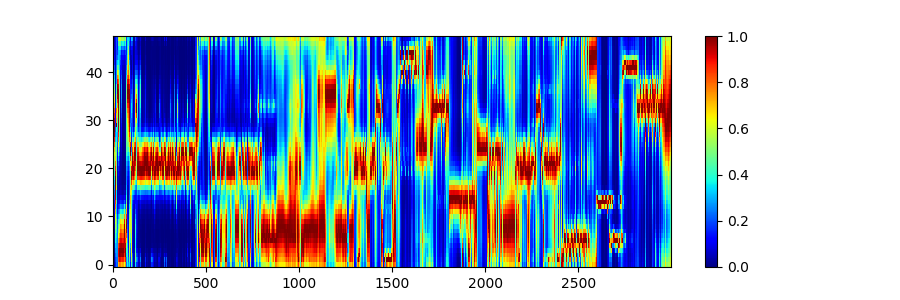

In [73]:
plt.figure(figsize=(9,3))
plt.imshow(filt_spec.T, origin='lower', aspect='auto',cmap='jet');
plt.colorbar(format='%.1f')
# for ann in annotations:
#         plt.axvline(x=ann*100, color='w', linestyle=':', linewidth=2);
plt.savefig('{}.eps'.format(n_chroma))

## Example 

Text(0.5,0,'Time [s]')

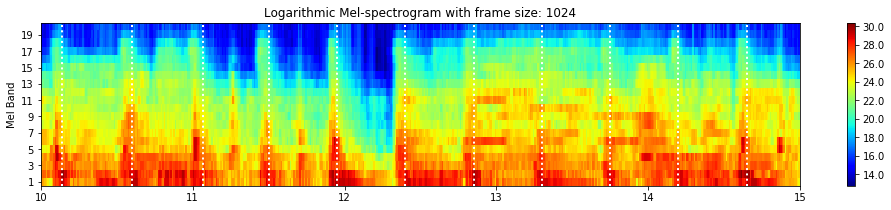

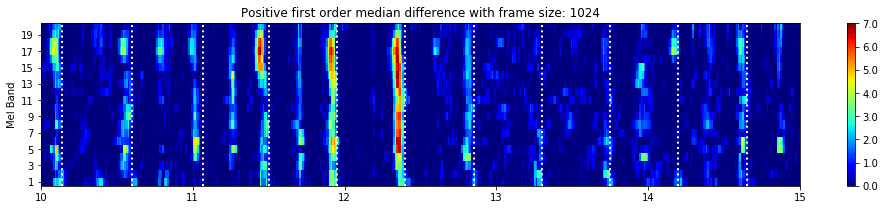

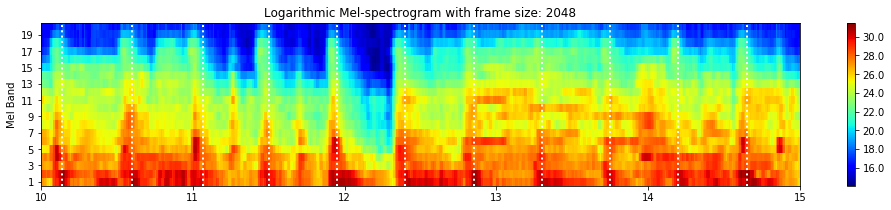

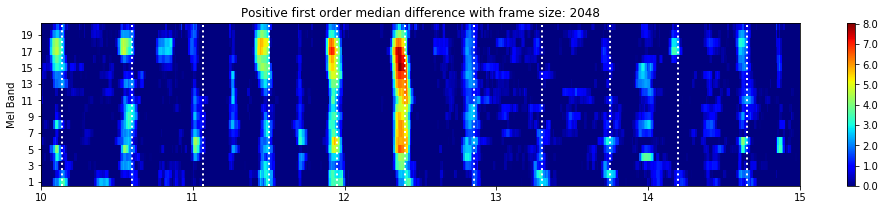

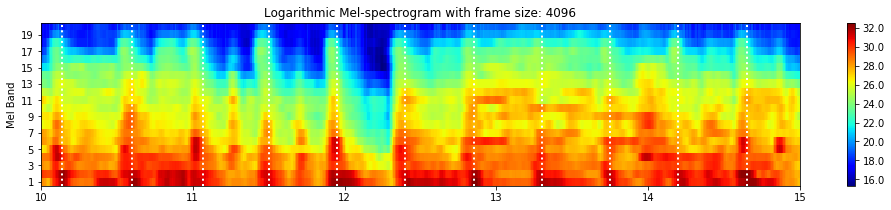

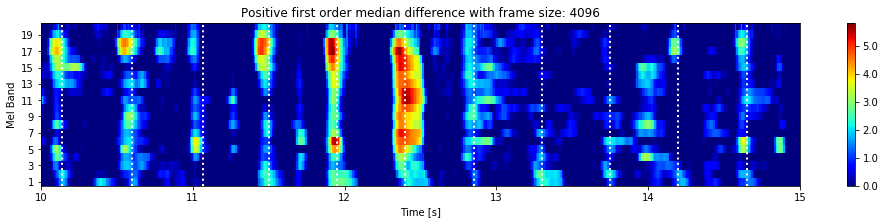

In [30]:
index = 260

input = get_input(data.at[index,'file'])
annotations = get_annotations(data.at[index,'file'])
predictions = get_predictions(data.at[index,'file'])

start = 10
end = 15
num_bands = 20
frame_rate = 100

title = ['Logarithmic Mel-spectrogram with frame size: 1024', 
         'Positive first order median difference with frame size: 1024',
         'Logarithmic Mel-spectrogram with frame size: 2048', 
         'Positive first order median difference with frame size: 2048',
         'Logarithmic Mel-spectrogram with frame size: 4096', 
         'Positive first order median difference with frame size: 4096']

for i in range(6):
    plt.figure(figsize=(17,3))
    plt.title(title[i])

    plt.imshow(np.array(input).T[i*20:(i+1)*20,start*frame_rate:end*frame_rate], 
               extent=(start,end, 0.5, num_bands+0.5),
               origin='lower', aspect='auto',cmap='jet');
    plt.yticks(np.arange(1,20,2));
    plt.ylim(0.5,num_bands+0.5)

    plt.colorbar(format='%.1f');
    
    plt.ylabel('Mel Band');

    for ann in predictions:
        plt.axvline(x=ann, color='w', linestyle=':', linewidth=2)
    plt.xlim(start, end)

plt.xlabel('Time [s]')


Wie sollen die Features normalisiert werden? <br>
Mit Hinblick auf die Eingangsdaten?

## Appendix

In [14]:
# Median Bildung
a = np.random.randn(5,3)
# print('a:\n', a, '\n')

shift_length = 5

median = [np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-shift,:] for shift in range(1, shift_length+1)]
median = np.insert(median, 0, a, axis=0)

# print('median:\n', median)

median = np.median(median, axis=0)

# shift = 1
# np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-1,:]